In [10]:
import os, sys
import time
import json

from collections import defaultdict

import matplotlib.pyplot as plt

import bz2
import gzip
import zlib

import tempfile

In [11]:
import xgboost as xgb
from time import time
import math

def mean_and_std(data):
    # Calculate mean
    mean = sum(data) / len(data)

    # Calculate standard deviation
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = math.sqrt(variance)

    return {
        "mean": mean,
        "std" : std_dev
    }

In [12]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost"

daily_path = xgboost_path + "/daily"
daily_100 = daily_path + "/100trees"
daily_1000 = daily_path + "/1000trees"
daily_10000 = daily_path + "/10000trees"

In [13]:
def load_model_json(model_path):
    booster = xgb.Booster()
    booster.load_model(model_path)
    return booster


def save_model_json(booster, model_path):
    booster.save_model(model_path)

In [14]:
def save_model_compressed(booster, model_path, compression_func, suffix=".json"):
    temp_model_path = tempfile.mktemp(suffix=suffix)
    booster.save_model(temp_model_path)

    # Read the JSON data from the temporary file
    with open(temp_model_path, "rb") as f:
        model_binary = f.read()

    # Compress byte stream
    compressed = compression_func(model_binary)

    # Write compressed data to a file
    with open(model_path, "wb") as outfile:
        outfile.write(compressed)


def load_model_compressed(model_path, decompression_func, suffix=".json"):
    # Read and unpack the MessagePack data
    with open(model_path, "rb") as f:
        packed_data = f.read()
    model = decompression_func(packed_data)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp(suffix=suffix)
    with open(temp_model_path, "wb") as f:
        f.write(model)
    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [15]:
def get_metrics(model_dir):
    dt_json_load = []
    dt_json_save = []
    json_sizes = []

    dt_gzip_load = []
    dt_gzip_save = []
    gzip_sizes = []

    dt_bz2_load = []
    dt_bz2_save = []
    bz2_sizes = []

    dt_ubj_load = []
    dt_ubj_save = []
    ubj_sizes = []

    dt_ubj_gzip_load = []
    dt_ubj_gzip_save = []
    ubj_gzip_sizes = []

    dt_ubj_bz2_load = []
    dt_ubj_bz2_save = []
    ubj_bz2_sizes = []

    for model_file in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_file)
        # JSON
        t0 = time()
        booster = load_model_json(model_path)
        dt_json_load.append(time() - t0)
        # Save
        t0 = time()
        save_model_json(booster, model_path)
        dt_json_save.append(time() - t0)
        # Size
        json_size = os.path.getsize(model_path)
        json_sizes.append(1.0)

        # Gzip
        gzip_path = "gzip.bin"
        # Save
        t0 = time()
        save_model_compressed(booster, gzip_path, gzip.compress)
        dt_gzip_save.append(time() - t0)
        # Load
        t0 = time()
        gzip_booster = load_model_compressed(gzip_path, gzip.decompress)
        dt_gzip_load.append(time() - t0)
        # Size
        gzip_sizes.append(json_size / os.path.getsize(gzip_path))

        # Bz2
        bz2_path = "bz2.bin"
        t0 = time()
        save_model_compressed(booster, bz2_path, bz2.compress)
        dt_bz2_save.append(time() - t0)
        # Load
        t0 = time()
        load_model_compressed(bz2_path, bz2.decompress)
        dt_bz2_load.append(time() - t0)
        # Size
        bz2_sizes.append(json_size / os.path.getsize(bz2_path))

        # UBJ
        # Save
        ubj_path = "model.ubj"
        t0 = time()
        save_model_json(booster, ubj_path)
        dt_ubj_save.append(time() - t0)
        # Load
        t0 = time()
        load_model_json(ubj_path)
        dt_ubj_load.append(time() - t0)
        # Size
        ubj_sizes.append(json_size / os.path.getsize(ubj_path))

        # UBJ Gzip
        ubj_gzip_path = "ubj_gzip.bin"
        # Save
        t0 = time()
        save_model_compressed(booster, ubj_gzip_path, gzip.compress, suffix=".ubj")
        dt_ubj_gzip_save.append(time() - t0)
        # Load
        t0 = time()
        load_model_compressed(ubj_gzip_path, gzip.decompress, suffix=".ubj")
        dt_ubj_gzip_load.append(time() - t0)
        # Size
        ubj_gzip_sizes.append(json_size / os.path.getsize(ubj_gzip_path))

        # UBJ Bz2
        ubj_bz2_path = "ubj_bz2.bin"
        t0 = time()
        save_model_compressed(booster, ubj_bz2_path, bz2.compress, suffix=".ubj")
        dt_ubj_bz2_save.append(time() - t0)
        # Load
        t0 = time()
        load_model_compressed(ubj_bz2_path, bz2.decompress, suffix=".ubj")
        dt_ubj_bz2_load.append(time() - t0)
        # Size
        ubj_bz2_sizes.append(json_size / os.path.getsize(ubj_bz2_path))

        # Cleanup
        os.remove(gzip_path)
        os.remove(bz2_path)
        os.remove(ubj_path)
        os.remove(ubj_gzip_path)
        os.remove(ubj_bz2_path)

    # Evaluation
    dt_load = {
        "JSON": mean_and_std(dt_json_load),
        "GZIP": mean_and_std(dt_gzip_load),
        "BZ2": mean_and_std(dt_bz2_load),
        "UBJ": mean_and_std(dt_ubj_load),
        "UBJ+GZIP": mean_and_std(dt_ubj_gzip_load),
        "UBJ+BZ2": mean_and_std(dt_ubj_bz2_load),
    }
    # Save
    dt_save = {
        "JSON": mean_and_std(dt_json_save),
        "GZIP": mean_and_std(dt_gzip_save),
        "BZ2": mean_and_std(dt_bz2_save),
        "UBJ": mean_and_std(dt_ubj_save),
        "UBJ+GZIP": mean_and_std(dt_ubj_gzip_save),
        "UBJ+BZ2": mean_and_std(dt_ubj_bz2_save),
    }

    # Size
    sizes = {
        "JSON": mean_and_std(json_sizes),
        "GZIP": mean_and_std(gzip_sizes),
        "BZ2": mean_and_std(bz2_sizes),
        "UBJ": mean_and_std(ubj_sizes),
        "UBJ+GZIP": mean_and_std(ubj_gzip_sizes),
        "UBJ+BZ2": mean_and_std(ubj_bz2_sizes),
    }

    return sizes, dt_save, dt_load

In [16]:
sizes_100, save_100, load_100 = get_metrics(daily_100)

In [17]:
sizes_1000, save_1000, load_1000 = get_metrics(daily_1000)

In [18]:
sizes_10000, save_10000, load_10000 = get_metrics(daily_10000)

In [23]:
import matplotlib.pyplot as plt
import numpy as np


def plot(sample1, sample2, sample3, ylabel, title):
    # Organizing the data
    means_json = [
        sample1["JSON"]["mean"],
        sample2["JSON"]["mean"],
        sample3["JSON"]["mean"],
    ]
    stds_json = [sample1["JSON"]["std"], sample2["JSON"]["std"], sample3["JSON"]["std"]]

    means_gzip = [
        sample1["GZIP"]["mean"],
        sample2["GZIP"]["mean"],
        sample3["GZIP"]["mean"],
    ]
    stds_gzip = [sample1["GZIP"]["std"], sample2["GZIP"]["std"], sample3["GZIP"]["std"]]

    means_bz2 = [
        sample1["BZ2"]["mean"],
        sample2["BZ2"]["mean"],
        sample3["BZ2"]["mean"],
    ]
    stds_bz2 = [
        sample1["BZ2"]["std"],
        sample2["BZ2"]["std"],
        sample3["BZ2"]["std"],
    ]

    means_ubj = [
        sample1["UBJ"]["mean"],
        sample2["UBJ"]["mean"],
        sample3["UBJ"]["mean"],
    ]
    stds_ubj = [sample1["UBJ"]["std"], sample2["UBJ"]["std"], sample3["UBJ"]["std"]]

    means_ubj_gzip = [
        sample1["UBJ+GZIP"]["mean"],
        sample2["UBJ+GZIP"]["mean"],
        sample3["UBJ+GZIP"]["mean"],
    ]
    stds_ubj_gzip = [
        sample1["UBJ+GZIP"]["std"],
        sample2["UBJ+GZIP"]["std"],
        sample3["UBJ+GZIP"]["std"],
    ]

    means_ubj_bz2 = [
        sample1["UBJ+BZ2"]["mean"],
        sample2["UBJ+BZ2"]["mean"],
        sample3["UBJ+BZ2"]["mean"],
    ]
    stds_ubj_bz2 = [
        sample1["UBJ+BZ2"]["std"],
        sample2["UBJ+BZ2"]["std"],
        sample3["UBJ+BZ2"]["std"],
    ]

    # Sample labels
    labels = ["100 Trees", "1000 Trees", "10000 Trees"]

    # Setting the positions of the bars
    x = np.arange(len(labels))  # the sample locations
    width = 0.15  # the width of the bars

    # Creating the plot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, means_json, width, yerr=stds_json, label="JSON")
    rects2 = ax.bar(x, means_gzip, width, yerr=stds_gzip, label="JSON+GZIP")
    rects3 = ax.bar(x + width, means_bz2, width, yerr=stds_bz2, label="JSON+BZ2")
    rects5 = ax.bar(
        x + (2 * width), means_ubj_gzip, width, yerr=stds_ubj_gzip, label="UBJ+GZIP"
    )
    rects6 = ax.bar(
        x + (3 * width), means_ubj_bz2, width, yerr=stds_ubj_bz2, label="UBJ+BZ2"
    )

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to attach a text label above each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    # Attaching the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects5)
    autolabel(rects6)

    # Showing the plot
    plt.tight_layout()
    plt.show()

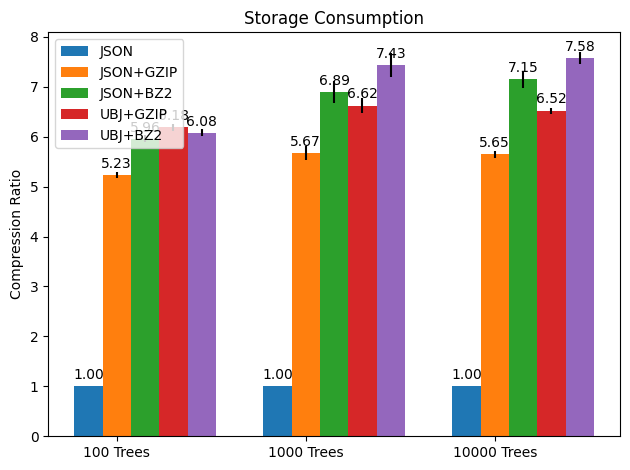

In [24]:
plot(sizes_100, sizes_1000, sizes_10000, ylabel="Compression Ratio", title="Storage Consumption")

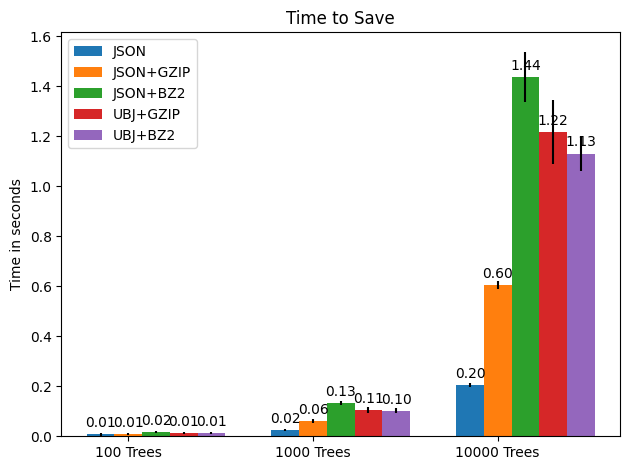

In [25]:
plot(save_100, save_1000, save_10000, ylabel="Time in seconds", title="Time to Save")

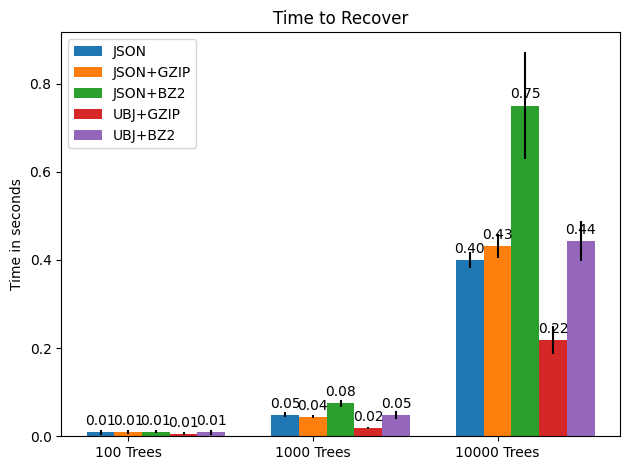

In [26]:
plot(load_100, load_1000, load_10000, ylabel="Time in seconds", title="Time to Recover")